# Data Exploration — Legal Text Decoder

Gyors EDA a `data/final/train.csv` és `data/final/test.csv` fájlokra:
- alap méretek, hiányzó értékek
- szöveghossz statisztikák és hisztogram
- címkedisztribúció
- szöveghossz átlag címkénként
- példasorok címkénként
- top tokenek és bigramok (gyors áttekintés)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path("../data/final")
train_path = data_dir / "train.csv"
test_path = data_dir / "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,text,label
0,1. Szerződés tárgya\nA Vállalkozó az alvállalk...,3
1,2.3. A vállalkozói díj magában foglalja a Váll...,4
2,2.4. Vállalkozó köteles az átadott tervek mér...,4
3,"3.1. A Szerződő felek megállapodnak abban, hog...",3
4,3.4. A szerződés tárgyát képező feladat akkor ...,3


In [7]:
summary = {
    "train_shape": train_df.shape,
    "test_shape": test_df.shape,
    "columns": train_df.columns.tolist(),
    "train_missing": train_df.isna().sum().to_dict(),
    "test_missing": test_df.isna().sum().to_dict(),
}
summary

{'train_shape': (3154, 2),
 'test_shape': (581, 2),
 'columns': ['text', 'label'],
 'train_missing': {'text': 0, 'label': 0},
 'test_missing': {'text': 0, 'label': 0}}

train length describe:
 count    3154.000000
mean      417.484147
std       529.323789
min        15.000000
25%       179.000000
50%       311.000000
75%       503.000000
max      9223.000000
Name: text_len, dtype: float64 

test length describe:
 count     581.000000
mean      397.790017
std       394.105234
min        15.000000
25%       154.000000
50%       293.000000
75%       501.000000
max      3921.000000
Name: text_len, dtype: float64 



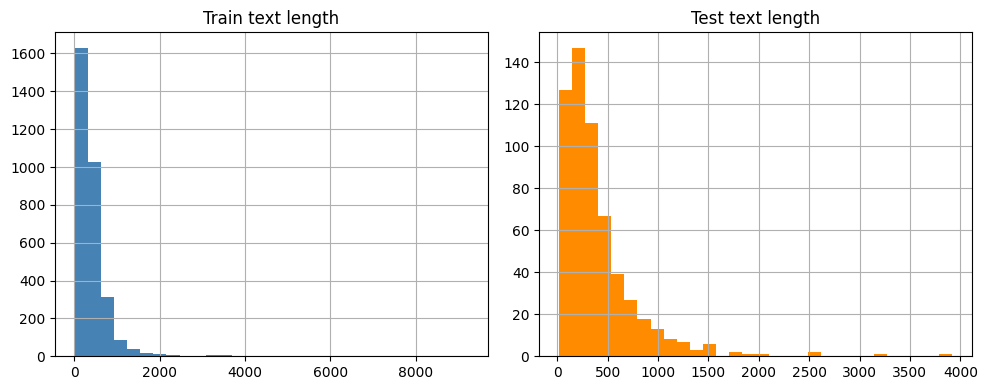

In [8]:
# Szöveghossz statisztika és hisztogram
for df, name in [(train_df, "train"), (test_df, "test")]:
    df["text_len"] = df["text"].str.len()
    print(f"{name} length describe:\n", df["text_len"].describe(), "\n")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
train_df["text_len"].hist(ax=ax[0], bins=30, color="steelblue")
ax[0].set_title("Train text length")
test_df["text_len"].hist(ax=ax[1], bins=30, color="darkorange")
ax[1].set_title("Test text length")
plt.tight_layout()
plt.show()

label
1    139
2    371
3    705
4    978
5    961
Name: count, dtype: int64

label
1     61
2     79
3    109
4    142
5    190
Name: count, dtype: int64

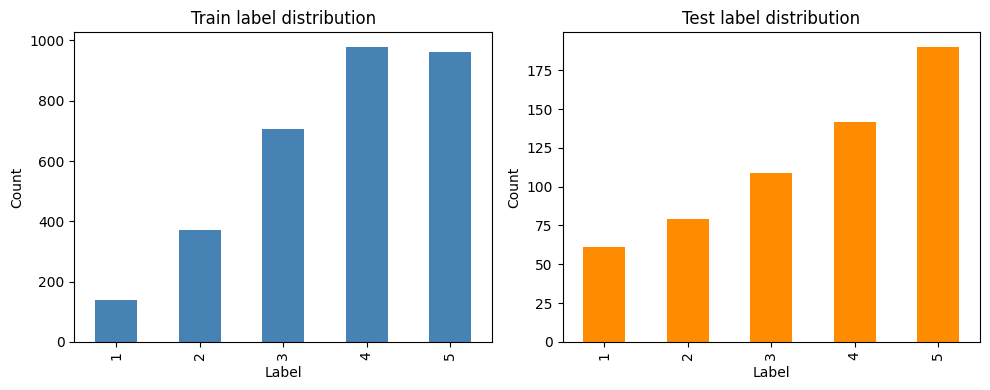

In [9]:
# Címkedisztribúció
label_counts_train = train_df["label"].value_counts().sort_index()
label_counts_test = test_df["label"].value_counts().sort_index()
display(label_counts_train)
display(label_counts_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
label_counts_train.plot(kind="bar", ax=ax[0], color="steelblue", title="Train label distribution")
label_counts_test.plot(kind="bar", ax=ax[1], color="darkorange", title="Test label distribution")
for a in ax:
    a.set_xlabel("Label")
    a.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [10]:
# Átlagos szöveghossz címkénként (train)
avg_len_by_label = train_df.groupby("label")["text_len"].mean()
avg_len_by_label

label
1    743.474820
2    757.614555
3    512.371631
4    378.828221
5    208.752341
Name: text_len, dtype: float64

In [11]:
# Példa sorok címkénként (train)
samples = []
for lbl in sorted(train_df["label"].unique()):
    sample_text = train_df.loc[train_df["label"] == lbl, "text"].iloc[0]
    samples.append({"label": lbl, "sample": sample_text[:300]})
samples

[{'label': np.int64(1),
  'sample': '8.1. Megrendelő a Vállalkozó által benyújtott részszámlák összegéből a nettó\nösszeg 10 % -át teljesítési garanciaként visszatartja. A visszatartott teljesítési\ngarancia 50 % -a a sikeres átadás -átvételi eljárást követően átalakul jóteljesítési\ngaranciává, amely, valamint a végszámla nettó összegéne'},
 {'label': np.int64(2),
  'sample': '4.1. Amennyiben a Vállalkozó nem átalányáras szerződést kötött a Megrendelővel,\núgy Vállalkozó a Megrendelő által leigazolt tételes felmérés alapján jogosult\nszámla benyújtására. Számla csak és kizárólag a Megrendelő képviselője által\nleigazolt és minden fél által aláírt teljesítés igazolása alapján'},
 {'label': np.int64(3),
  'sample': '1. Szerződés tárgya\nA Vállalkozó az alvállalkozói szerződésben megjelölt (elvállalt) munkákat a hatályos\njogszabályok, hatósági előírások, szabványok, műszaki normatívák betartásával a\nmagyar szabvány szerinti I. osztályú minőségben, rendeltetésszerű használatra\nalkalmas

In [12]:
# Top tokenek (unigram, gyors tokenizálás)
from collections import Counter
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

counter = Counter()
for t in train_df["text"].head(2000):
    counter.update(tokenize(t))

top_tokens = counter.most_common(20)
pd.DataFrame(top_tokens, columns=["token", "count"])

,token,count
0,a,11171
1,az,4127
2,és,2184
3,nem,1338
4,vagy,1305
5,hogy,629
6,vállalkozó,528
7,köteles,528
8,ha,502
9,szerződés,493


In [13]:
# Top bigramok (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(2,2), max_features=20)
X = vec.fit_transform(train_df["text"])
sums = X.sum(axis=0).A1
bigrams = pd.DataFrame({"bigram": vec.get_feature_names_out(), "count": sums}).sort_values("count", ascending=False)
bigrams

,bigram,count
19,és az,296
2,az alza,227
9,az ügyfél,216
3,az eladó,208
13,hogy az,206
14,jelen ászf,186
12,ha az,173
1,az adott,171
15,napon belül,168
17,vagy az,163
